As AI-generated content becomes increasingly sophisticated, distinguishing real from synthetic media has become a critical ethical challenge. Motivated by a strong interest in ethical AI and combating misinformation, this project explores image classification techniques to detect AI-generated faces,particularly those created using advanced models like Stable Diffusion. Using Python and PyTorch on Google Colab, I fine-tuned a pretrained image classifier (Xception) to differentiate between real human images and synthetic ones, aiming to build a lightweight, effective detection model that contributes to the broader conversation around AI transparency and digital trust.

Data Sources:
This project uses two primary datasets sourced from Kaggle. The real human face images come from the "AI Face Detection Dataset" by shahzaibshazoo, which provides high-quality, unaltered photos of real people. For AI-generated faces, I used the "AI vs Human Syn Images V2" dataset by gpch2159, which includes synthetic images created using Stable Diffusion, a state-of-the-art generative AI model. To ensure balanced training, I sampled a subset of the synthetic images to maintain a 1:1 ratio of AI to real faces. These curated datasets provide a realistic and challenging base for training a robust classifier.

dataset : https://www.kaggle.com/datasets/shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset/data

https://www.kaggle.com/datasets/gpch2159/ai-vs-human-syn-imgs-v2-partial/data?select=stabilityai.stable-diffusion-xl-refiner-1.0_0.5_12_2025.02.25_05.15.08_846327


In [ ]:
# Install necessary libraries
!pip install torchvision timm


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os
import timm  # for pretrained Xception
print("GPU available:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


GPU available: True


In this phase of the project, I began by gathering and organizing my image data. I used two publicly available datasets from Kaggle to build a binary classification dataset: one containing **real human face images** and another containing **AI-generated face images**, specifically those created using **Stable Diffusion**, a powerful image generation model.

The real image dataset was downloaded from the Kaggle repository titled *“detect-ai-generated-faces-high-quality-dataset”*. From this dataset, I extracted all the images in the `real` folder and labeled them with `1` to indicate that they are authentic, human-taken photographs.

For the AI-generated images, I used a separate dataset called *“ai-vs-human-syn-imgs-v2-partial”*, which contains synthetic faces produced by Stable Diffusion. I accessed the relevant subfolder where the generated images were stored and assigned each of them a label `0` to mark them as fake or AI-generated.

After collecting both sets of images, I combined their file paths and respective labels into a single **Pandas DataFrame**. This structured dataset is now ready for preprocessing, visualization, and eventually training a classification model. At this stage, I also printed out the number of images in each category to get a quick sense of dataset balance — a step that will inform any future resampling or augmentation decisions.


In [ ]:
import os
import glob
import pandas as pd
import kagglehub

# 1. Download real image dataset
base_dir = kagglehub.dataset_download("shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset")
real_image_dir = os.path.join(base_dir, "AI-face-detection-Dataset", "real")
real_images = glob.glob(os.path.join(real_image_dir, "*.*"))
real_labels = [1] * len(real_images)

# 2. Download Stable Diffusion images (AI-generated)
sd_base = kagglehub.dataset_download("gpch2159/ai-vs-human-syn-imgs-v2-partial")
sd_image_dir = os.path.join(sd_base, "stabilityai.stable-diffusion-xl-refiner-1.0_0.5_12_2025.02.25_05.15.08_846327")
ai_images = glob.glob(os.path.join(sd_image_dir, "*.*"))
ai_labels = [0] * len(ai_images)

# 3. Combine both into a DataFrame
file_paths = real_images + ai_images
labels = real_labels + ai_labels
df = pd.DataFrame({'file_path': file_paths, 'label': labels})

# 4. Print counts
print("Stable Diffusion (AI) images found:", len(ai_images))
print("Real images found:", len(real_images))
print("Total images:", len(df))


Stable Diffusion (AI) images found: 30440
Real images found: 2202
Total images: 32642


This block balances the dataset by sampling a smaller subset of AI-generated images to achieve a 1.5:1 ratio of fake to real images. First, it creates separate DataFrames for real and AI images with their respective labels (1 for real, 0 for AI). Then, it randomly selects a subset of AI images equal to 1.5 times the number of real images. Finally, the sampled AI images and real images are combined, shuffled, and reset into a new balanced DataFrame. The class distribution is printed at the end to verify the result.

In [ ]:
import pandas as pd

# 1. Convert lists to DataFrames
real_df = pd.DataFrame({'file_path': real_images, 'label': 1})
ai_df = pd.DataFrame({'file_path': ai_images, 'label': 0})

# 2. Sample 1.5x AI images
ai_sample_size = int(1 * len(real_df))
ai_df_sampled = ai_df.sample(n=ai_sample_size, random_state=42)

# 3. Combine and shuffle
df = pd.concat([real_df, ai_df_sampled], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 4. Confirm new balance
print("Class distribution:\n", df['label'].value_counts())


In [ ]:
'''import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
import kagglehub

# Dataset base path from KaggleHub
base_dir = kagglehub.dataset_download("shahzaibshazoo/detect-ai-generated-faces-high-quality-dataset")

# Construct image directories
ai_image_dir = os.path.join(base_dir, "AI-face-detection-Dataset", "AI")
real_image_dir = os.path.join(base_dir, "AI-face-detection-Dataset", "real")

# Load image file paths
ai_images = glob.glob(os.path.join(ai_image_dir, "*.*"))
real_images = glob.glob(os.path.join(real_image_dir, "*.*"))

print("AI images found:", len(ai_images))
print("Real images found:", len(real_images))

# Label AI images as 1, real as 0
df_ai = pd.DataFrame({"file_name": ai_images, "label": 1})
df_real = pd.DataFrame({"file_name": real_images, "label": 0})

# Combine the two
df = pd.concat([df_ai, df_real], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle'''

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, train_size=0.8, stratify=df["label"], random_state=42)



This block sets up the **data preprocessing and loading** needed for training a PyTorch model.

1. **Transformations**:
   A transformation pipeline is created using `torchvision.transforms`. It resizes images to **299×299 pixels** (ideal for models like Xception), converts them to tensors, and normalizes pixel values to center them around 0.
   Normalization uses a mean and standard deviation of 0.5 for each color channel.

2. **Custom Dataset Class**:
   A subclass of `torch.utils.data.Dataset` called `CustomImageDataset` is defined. This class:

   * Accepts a DataFrame containing image paths and labels.
   * Loads an image at a given index using PIL.
   * Applies the defined transformations (if any).
   * Returns a tuple `(image_tensor, label)` for that index.

This setup allows efficient and structured loading of image-label pairs into PyTorch `DataLoader`s for training and validation.


In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'file_path']
        label = int(self.dataframe.loc[idx, 'label'])

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


This block prepares the training and validation data for the model by creating PyTorch-compatible datasets and data loaders.

First, the `CustomImageDataset` class (defined earlier) is used to wrap the training and validation DataFrames (`train_df` and `val_df`) along with the image transformation pipeline (`transform`). This creates `train_dataset` and `val_dataset`, which are responsible for loading and preprocessing individual images and their labels.

Then, `DataLoader` is used to wrap each dataset into iterable objects, `train_loader` and `val_loader`. These loaders handle batching (with a batch size of 16) and shuffling (enabled for training to improve generalization, but disabled for validation to keep consistency). The `DataLoader` efficiently feeds data to the model during training and evaluation.


In [ ]:
train_dataset = CustomImageDataset(train_df, transform=transform)
val_dataset = CustomImageDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


This code initializes the image classification model using the Xception architecture from the `timm` library, preloaded with weights trained on the ImageNet dataset. It customizes the model for a binary classification task by setting `num_classes=2`, then moves it to the appropriate device (GPU or CPU) for training. To guide learning, it sets up the cross-entropy loss function, which measures how well the model's predictions match the true labels. Finally, it uses the Adam optimizer with a learning rate of 0.0001 to adjust the model's weights efficiently during training.


In [ ]:
model = timm.create_model('xception', pretrained=True, num_classes=2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


This block of code defines and executes the training and evaluation process for the image classification model over multiple epochs.

The `train_one_epoch` function trains the model for one full pass through the training data. It sets the model to training mode (`model.train()`), loops over batches of images and labels, moves the data to the appropriate device (GPU/CPU), performs forward propagation to get predictions, calculates the loss, and updates the model’s weights through backpropagation and the optimizer. It also tracks the average loss and accuracy for the epoch.

The `evaluate` function is used to assess the model’s performance on the validation set without updating weights. It switches the model to evaluation mode (`model.eval()`), disables gradient calculation for efficiency (`torch.no_grad()`), and computes the validation accuracy.

Finally, the training loop runs for a defined number of epochs (`num_epochs = 5`), calling the training and evaluation functions in each iteration. After every epoch, it prints the training loss, training accuracy, and validation accuracy to monitor performance.


In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total, correct, running_loss = 0, 0, 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss/len(loader), correct/total

def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct/total

num_epochs = 5
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)
    print(f'Epoch {epoch+1}/{num_epochs} — '
          f'Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, '
          f'Val acc: {val_acc:.4f}')


Epoch 1/5 — Train loss: 0.0624, Train acc: 0.9892, Val acc: 0.9989
Epoch 2/5 — Train loss: 0.0024, Train acc: 1.0000, Val acc: 0.9989
Epoch 3/5 — Train loss: 0.0032, Train acc: 0.9997, Val acc: 0.9989
Epoch 4/5 — Train loss: 0.0042, Train acc: 0.9991, Val acc: 0.9989
Epoch 5/5 — Train loss: 0.0159, Train acc: 0.9972, Val acc: 0.9989


In [ ]:
final_val_acc = evaluate(model, val_loader)
print(f"Final Validation Accuracy: {final_val_acc:.4f}")


Final Validation Accuracy: 0.9989


This code evaluates the model on the validation set and displays a confusion matrix to visualize performance. It collects the true and predicted labels, computes the confusion matrix, and then plots it using the defined class names `'AI'` and `'real'`. This helps identify how well the model distinguishes between the two classes.


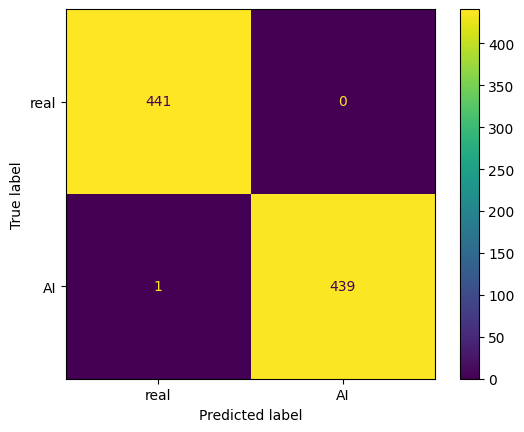

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

# Define class names explicitly
class_names = ['AI', 'real']

# Pass the defined class_names to ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm, display_labels=class_names).plot()


This block evaluates the trained model on the validation set and provides a detailed performance summary. It first collects the true and predicted labels across all batches without updating the model (in evaluation mode). Then, it prints a **classification report** showing precision, recall, and F1-score for each class, along with a **confusion matrix** to visualize the counts of true vs. predicted labels. This gives a clear overview of how well the model performs on each category (`AI` and `real`).


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       1.00      1.00      1.00       440

    accuracy                           1.00       881
   macro avg       1.00      1.00      1.00       881
weighted avg       1.00      1.00      1.00       881

[[441   0]
 [  1 439]]


This function, `predict_image`, allows you to use your trained model to classify a **single image**. Here's what it does:

1. **Loads and preprocesses** the image using the same transformation pipeline used during training (resizing, normalization, etc.).
2. **Adds a batch dimension** to the image so it can be passed through the model (since PyTorch models expect batched input).
3. **Disables gradient computation** with `torch.no_grad()` and runs the image through the model in evaluation mode.
4. **Gets the predicted class** index using `torch.max`, then converts it to the actual class label using the provided `class_names` list (e.g., `["AI", "real"]`).

This is useful for testing your model on individual images after training.


In [ ]:
from PIL import Image

def predict_image(img_path, model, transform, class_names):
    # Load image and apply same transforms as training
    image = Image.open(img_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()  # Set to eval mode
    with torch.no_grad():
        output = model(image)
        _, pred = torch.max(output, 1)

    return class_names[pred.item()]





In [ ]:
#image path
img_path = '/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/0065d47a13fc4608a55be23d02a0f523.jpg'

# Same transform as training
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

#class labels
class_names = ['AI', 'real']

result = predict_image(img_path,model, transform, class_names)
print(f"Prediction: {result}")


Prediction: AI


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then save to a folder in your drive
torch.save(model.state_dict(), '/content/drive/MyDrive/real_vs_fake_SD_classification_model.pth')


Mounted at /content/drive
